## Cargar OBT

In [2]:
# cargar el OBT desde pgadmin
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
import os
from dotenv import load_dotenv
from pyspark.sql import SparkSession


In [3]:
load_dotenv(dotenv_path="/home/jovyan/work/.env")

PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DB = os.getenv("PG_DB")
PG_USER = os.getenv("PG_USER")
PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_SCHEMA_RAW = os.getenv("PG_SCHEMA_RAW")
PG_SCHEMA_ANALYTICS = os.getenv("PG_SCHEMA_ANALYTICS")



In [4]:
spark = SparkSession.builder \
    .appName("IngestaParquetPostgres") \
    .config("spark.jars.packages", "org.postgresql:postgresql:42.2.18") \
    .getOrCreate()

pgOptions = {
    "url": f"jdbc:postgresql://{os.getenv('PG_HOST', 'postgres-warehouse')}:{os.getenv('PG_PORT', '5432')}/{os.getenv('PG_DB', 'warehouse_db')}",
    "user": os.getenv("PG_USER", "postgres"),
    "password": os.getenv("PG_PASSWORD", "postgres"),
    "driver": "org.postgresql.Driver"
}

In [5]:
cols_keep = [
    '"PICKUP_HOUR"',
    '"DAY_OF_WEEK"', '"MONTH"', '"YEAR"',
    '"PU_LOCATION_ID"', '"PU_ZONE"', '"PU_BOROUGH"',
    '"SERVICE_TYPE"', '"VENDOR_NAME"',
    '"RATE_CODE_DESC"', '"PAYMENT_TYPE_DESC"', '"TRIP_TYPE_DESC"',
    '"PASSENGER_COUNT"', '"TRIP_DISTANCE"', '"STORE_AND_FWD_FLAG"',
    '"FARE_AMOUNT"', '"TOTAL_AMOUNT"',
    '"SOURCE_SERVICE"'
]

In [6]:

def load_sample(service, year, n=50000):
    query = f"""
        (SELECT {', '.join(cols_keep)} FROM analytics.obt_trips
         WHERE "SERVICE_TYPE"='{service}' AND "YEAR"={year}
         LIMIT {n}) AS tmp
    """
    return spark.read.jdbc(url=pgOptions["url"], table=query, properties=pgOptions)

# 2022
df_2022_yellow = load_sample("yellow", 2022, n=50000)
df_2022_green  = load_sample("green", 2022, n=50000)
df_2022 = df_2022_yellow.union(df_2022_green)

# 2023
df_2023_yellow = load_sample("yellow", 2023, n=50000)
df_2023_green  = load_sample("green", 2023, n=50000)
df_2023 = df_2023_yellow.union(df_2023_green)

# Unir ambos años para train
df_train = df_2022.union(df_2023)

# 2024 validation
df_2024_yellow = load_sample("yellow", 2024, n=50000)
df_2024_green  = load_sample("green", 2024, n=50000)
df_val = df_2024_yellow.union(df_2024_green)

# 2025 test
df_2025_yellow = load_sample("yellow", 2025, n=50000)
df_2025_green  = load_sample("green", 2025, n=50000)
df_test = df_2025_yellow.union(df_2025_green)



print("DataFrames cargados desde Postgres: ")


DataFrames cargados desde Postgres: 


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:

# unir todos los datos para visualizar 2022-2025
df_all = df_train.union(df_val).union(df_test).toPandas()


In [16]:
#guardar dataframe df_all como parquet
df_all.to_parquet(path="/home/jovyan/work/obt_trips_2022_2025.parquet", index=False)
print("DataFrame guardado como obt_trips_2022_2025.parquet")

DataFrame guardado como obt_trips_2022_2025.parquet


In [7]:
df_all = pd.read_parquet("obt_trips_2022_2025.parquet")

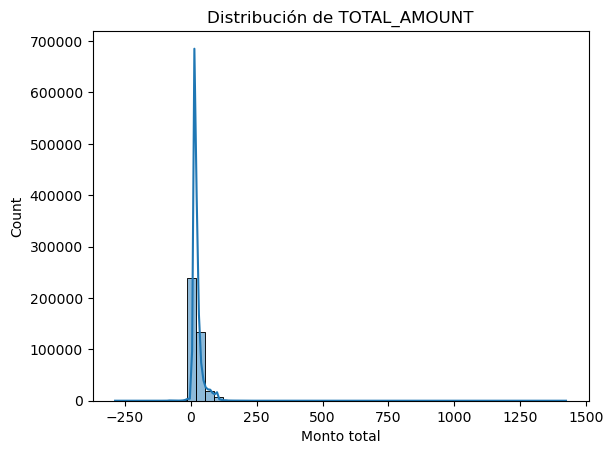

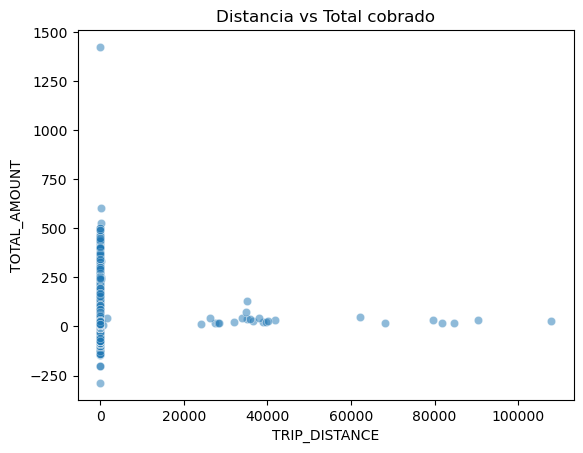

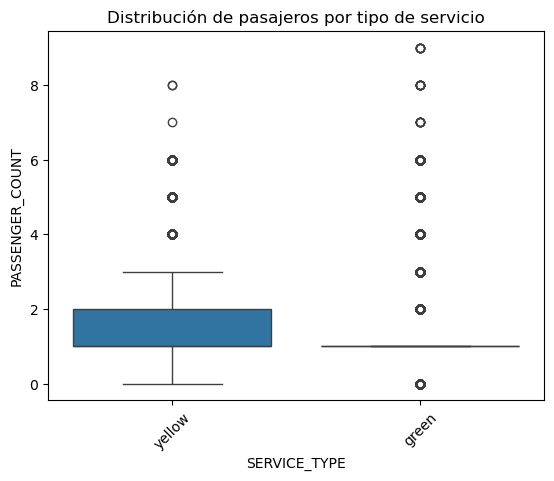

In [10]:
sns.histplot(df_all["TOTAL_AMOUNT"], bins=50, kde=True)
plt.title("Distribución de TOTAL_AMOUNT")
plt.xlabel("Monto total")
plt.show()

sns.scatterplot(data=df_all, x="TRIP_DISTANCE", y="TOTAL_AMOUNT", alpha=0.5)
plt.title("Distancia vs Total cobrado")
plt.show()

sns.boxplot(data=df_all, x="SERVICE_TYPE", y="PASSENGER_COUNT")
plt.title("Distribución de pasajeros por tipo de servicio")
plt.xticks(rotation=45)
plt.show()

# Limpieza

In [11]:

# Eliminar filas con pasajeros cero o negativos o mayor a 6

def clean_taxi_data_iqr(df, factor=1.5, max_price_per_mile=100, min_price_per_mile=3.5):
    """
    Limpia datos usando el método IQR para detectar outliers
    factor: multiplicador del IQR (1.5 es estándar,3 ser más conservador)
    max_price_per_mile: umbral máximo de precio por milla para eliminar outliers
    min_price_per_mile: umbral mínimo de precio por milla para eliminar outliers
    """
    df_clean = df.copy()
    df_clean = df_clean[(df_clean["PASSENGER_COUNT"] > 0) & (df_clean["PASSENGER_COUNT"] < 6)] 

    # Primero eliminar valores imposibles
    df_clean = df_clean[(df_clean['TRIP_DISTANCE'] > 0) & 
                        (df_clean['TOTAL_AMOUNT'] > 0)]
    
    df_clean['price_per_mile'] = df_clean['TOTAL_AMOUNT'] / df_clean['TRIP_DISTANCE']

    df_clean = df_clean[df_clean['price_per_mile'] <= max_price_per_mile]

    # minimun price per mile
    df_clean = df_clean[df_clean['price_per_mile'] >= min_price_per_mile]
    df_clean = df_clean.drop('price_per_mile', axis=1)
    
    for column in ['TRIP_DISTANCE', 'TOTAL_AMOUNT']:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        df_clean = df_clean[(df_clean[column] >= lower_bound) & 
                            (df_clean[column] <= upper_bound)]
    
    return df_clean

df_all_clean = clean_taxi_data_iqr(df_all, factor=3)


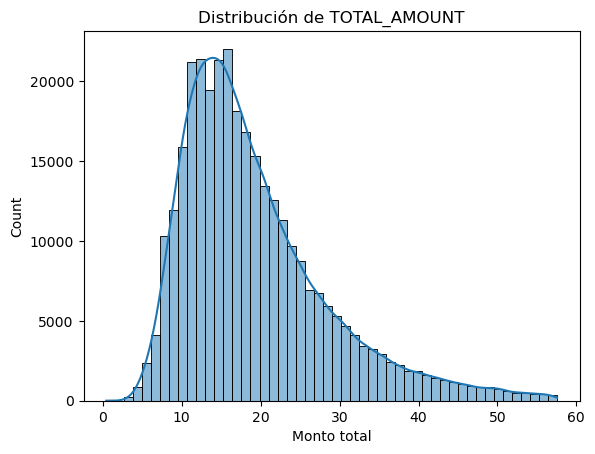

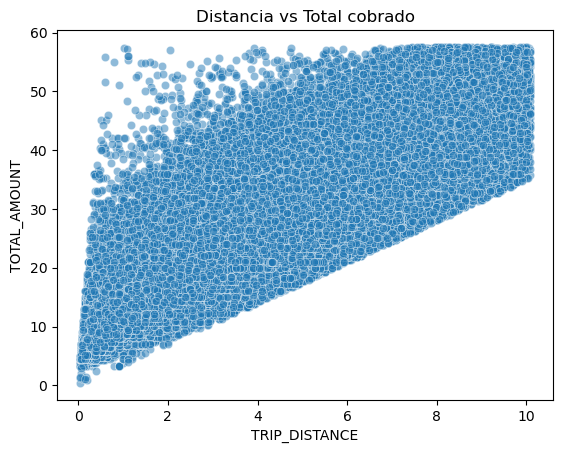

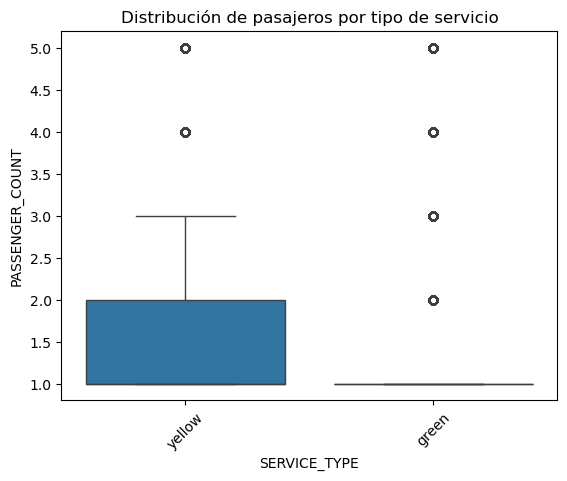

In [12]:
# graficar nuevamente
sns.histplot(df_all_clean["TOTAL_AMOUNT"], bins=50, kde=True)
plt.title("Distribución de TOTAL_AMOUNT")
plt.xlabel("Monto total")
plt.show()

sns.scatterplot(data=df_all_clean, x="TRIP_DISTANCE", y="TOTAL_AMOUNT", alpha=0.5)
plt.title("Distancia vs Total cobrado")
plt.show()

sns.boxplot(data=df_all_clean, x="SERVICE_TYPE", y="PASSENGER_COUNT")
plt.title("Distribución de pasajeros por tipo de servicio")
plt.xticks(rotation=45)
plt.show()

# Separacion train, val, test

In [13]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
from sklearn.base import BaseEstimator, TransformerMixin

r_seed = 42


# train 2022-2023, val 2024, test 2025 en pandas
df_train = df_all_clean[df_all_clean["YEAR"].isin([2022, 2023])]
df_val = df_all_clean[df_all_clean["YEAR"] == 2024]
df_test = df_all_clean[df_all_clean["YEAR"] == 2025]
print(f"Train shape: {df_train.shape}, Val shape: {df_val.shape}, Test shape: {df_test.shape}")

target = "TOTAL_AMOUNT"
feature_cols = [col for col in df_all_clean.columns if col != target]
num_cols = ["TRIP_DISTANCE", "PASSENGER_COUNT", "PICKUP_HOUR", "DAY_OF_WEEK", "MONTH", "YEAR"]
cat_cols = ["SOURCE_SERVICE", "VENDOR_NAME", "RATE_CODE_DESC", "PU_BOROUGH", "PU_ZONE", "PAYMENT_TYPE_DESC", "TRIP_TYPE_DESC", "STORE_AND_FWD_FLAG"]

# dropear pu_location_id (columna dividida en zone y borough) y service_type (columna repetida)

X_train = df_train.drop(columns=[target, "PU_LOCATION_ID", "SERVICE_TYPE"])
y_train = df_train[target]

X_val = df_val.drop(columns=[target, "PU_LOCATION_ID", "SERVICE_TYPE"])
y_val = df_val[target]

X_test = df_test.drop(columns=[target, "PU_LOCATION_ID", "SERVICE_TYPE"])
y_test = df_test[target]



Train shape: (164220, 18), Val shape: (86538, 18), Test shape: (70690, 18)


# Escalar datos

In [15]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import time


In [ ]:
# Escalar solo las variables numéricas

num_cols = ["TRIP_DISTANCE", "PASSENGER_COUNT", "PICKUP_HOUR", "DAY_OF_WEEK", "MONTH", "YEAR"]
cat_cols = ["SOURCE_SERVICE", "VENDOR_NAME", "RATE_CODE_DESC", "PU_BOROUGH", "PU_ZONE", "PAYMENT_TYPE_DESC", "TRIP_TYPE_DESC", "STORE_AND_FWD_FLAG"]

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cat = encoder.fit_transform(X_train[cat_cols])
X_val_cat = encoder.transform(X_val[cat_cols])
X_test_cat = encoder.transform(X_test[cat_cols])

X_train_final = np.hstack((X_train[num_cols].values, X_train_cat))
X_val_final = np.hstack((X_val[num_cols].values, X_val_cat))
X_test_final = np.hstack((X_test[num_cols].values, X_test_cat))


# Implementaciones propias

## SGD
----

In [ ]:
# Stochastic Gradient Descent con numpy 
class SGDRegressorScratch:
    def __init__(self, learning_rate=0.01, n_epochs=1000, alpha = 0.001, batch_size=2048):
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.alpha = alpha
        self.batch_size = batch_size         # sklearn usa mini-batch interno
        self.coef_ = None
        self.intercept_ = None
        self.costs = []

    def fit(self, X, y):
        # Asegurar arrays numpy
        X = np.array(X).astype(float)
        y = np.array(y).astype(float)
        n_samples, n_features = X.shape

        # Inicializar pesos
        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0 # inicializar intercepto

        # SGD
        for epoch in range(self.n_epochs):
            # Mezclar los datos como en sklearn
            idx = np.random.permutation(n_samples)
            X_shuffled = X[idx]
            y_shuffled = y[idx]
            # mini-batch para que sea SGD
            for start in range(0, n_samples, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                # Predicciones para el mini-batch
                y_pred = np.dot(X_batch, self.coef_) + self.intercept_
                # Calcular el error
                error = y_pred - y_batch
                # costo (MSE)
                cost = np.mean(error**2)
                self.costs.append(cost)
                # Gradientes
                gradient_w = (2/len(y_batch)) * np.dot(X_batch.T, error) + 2 * self.alpha * self.coef_
                gradient_b = (2/len(y_batch)) * np.sum(error)
                # Actualizar pesos
                self.coef_ -= self.learning_rate * gradient_w
                self.intercept_ -= self.learning_rate * gradient_b

        return self

    def predict(self, X):
        X = np.array(X).astype(float)
        return np.dot(X, self.coef_) + self.intercept_
    
    # R², RMSE, MAE
    def score(self, X, y):
        X = np.array(X).astype(float)
        y = np.array(y).astype(float)
        # R2
        y_pred = self.predict(X)
        ss_total = np.sum((y - np.mean(y)) ** 2)
        ss_residual = np.sum((y - y_pred) ** 2)
        r2_score = 1 - (ss_residual / ss_total)
        # RMSE
        rmse = np.sqrt(np.mean((y - y_pred) ** 2))
        # MAE
        mae = np.mean(np.abs(y - y_pred))
        return r2_score, rmse, mae
    

## Ridge
---

In [ ]:

class RidgeRegression:
    
    def __init__( self, learning_rate, n_epochs, l2_penality ):
        
        self.learning_rate = learning_rate        
        self.n_epochs = n_epochs        
        self.l2_penality = l2_penality
        
    # Function for model training            
    def fit( self, X, Y ):
        # Assegurar arrays numpy
        X = np.array(X).astype(float)
        Y = np.array(Y).astype(float)
        self.m, self.n = X.shape
        # inicialización de pesos
        self.W = np.zeros( self.n )
        
        self.b = 0        
        self.X = X        
        self.Y = Y
        
        # aprendizaje por descenso de gradiente
                
        for i in range( self.n_epochs):            
            self.update_weights()            
        return self
    
    # actualizar pesos en descenso de gradiente
    
    def update_weights( self ):           
        Y_pred = self.predict( self.X )
        # calcular gradientes      
        dW = ( - ( 2 * ( self.X.T ).dot( self.Y - Y_pred ) ) +               
               ( 2 * self.l2_penality * self.W ) ) / self.m     
        db = - 2 * np.sum( self.Y - Y_pred ) / self.m 
        
        # actualizar pesos    
        self.W = self.W - self.learning_rate * dW    
        self.b = self.b - self.learning_rate * db        
        return self
    
    # predicción
    def predict( self, X ):    
        X = np.array(X).astype(float)
        return X.dot( self.W ) + self.b
    
    def score( self, X, Y ):
        X = np.array(X).astype(float)
        Y = np.array(Y).astype(float)
        Y_pred = self.predict( X )
        ss_total = np.sum( ( Y - np.mean( Y ) ) ** 2 )
        ss_residual = np.sum( ( Y - Y_pred ) ** 2 )
        r2_score = 1 - ( ss_residual / ss_total )
        rmse = np.sqrt( np.mean( ( Y - Y_pred ) ** 2 ) )
        mae = np.mean( np.abs( Y - Y_pred ) )
        return r2_score, rmse, mae

## Lasso
---

In [ ]:
class LassoRegressionScratch:
    def __init__(self, learning_rate, n_epochs, l1_penalty):
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.l1_penalty = l1_penalty

    def fit(self, X, Y):
        # asegurar arrays numpy
        X = np.array(X).astype(float)
        Y = np.array(Y).astype(float)

        self.m, self.n = X.shape 
        self.W = np.zeros(self.n) # pesos iniciales
        self.b = 0 # bias inicial
        self.X = X
        self.Y = Y

        for i in range(self.n_epochs):
            self.update_weights() # actualizar pesos
        return self

    def update_weights(self):
        Y_pred = self.predict(self.X) # predicciones
      
        dW = np.zeros(self.n) # gradientes
        for j in range(self.n):
            if self.W[j] > 0: # gradiente positivo
                dW[j] = (-2 * (self.X[:, j]).dot(self.Y - Y_pred) +
                         self.l1_penalty) / self.m
            else: # gradiente negativo
                dW[j] = (-2 * (self.X[:, j]).dot(self.Y - Y_pred) -
                         self.l1_penalty) / self.m

        db = -2 * np.sum(self.Y - Y_pred) / self.m # gradiente bias

        self.W = self.W - self.learning_rate * dW # actualizar pesos
        self.b = self.b - self.learning_rate * db # actualizar bias
        return self

    def predict(self, X):
        X = np.array(X).astype(float)
        return X.dot(self.W) + self.b
    
    def score(self, X, Y):
        X = np.array(X).astype(float)
        Y = np.array(Y).astype(float)
        Y_pred = self.predict(X)
        ss_total = np.sum((Y - np.mean(Y)) ** 2)
        ss_residual = np.sum((Y - Y_pred) ** 2)
        r2_score = 1 - (ss_residual / ss_total)
        rmse = np.sqrt(np.mean((Y - Y_pred) ** 2))
        mae = np.mean(np.abs(Y - Y_pred))
        return r2_score, rmse, mae

## Elastic net

In [ ]:
class ElasticRegressionScratch():
    def __init__(self, alpha, l1_ratio, learning_rate, n_epochs):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.l1_penalty = alpha * l1_ratio
        self.l2_penalty = alpha * (1 - l1_ratio)

    def fit(self, X, Y):
        # asegurar arrays numpy
        X = np.array(X).astype(float)
        Y = np.array(Y).astype(float)

        self.m, self.n = X.shape
        self.W = np.zeros(self.n)
        self.b = 0
        self.X = X
        self.Y = Y
        for i in range(self.n_epochs):
            self.update_weights()
        return self

    def update_weights(self):
        Y_pred = self.predict(self.X)
        dW = np.zeros(self.n)
        for j in range(self.n):
            l1_grad = self.l1_penalty if self.W[j] > 0 else -self.l1_penalty # gradiente L1
            dW[j] = ( # gradiente combinado L1 y L2
                -2 * (self.X[:, j]).dot(self.Y - Y_pred) +
                l1_grad + 2 * self.l2_penalty * self.W[j]
            ) / self.m
        db = -2 * np.sum(self.Y - Y_pred) / self.m # gradiente bias
        self.W -= self.learning_rate * dW # actualizar pesos
        self.b -= self.learning_rate * db # actualizar bias
        return self

    def predict(self, X):
        X = np.array(X).astype(float)
        return X.dot(self.W) + self.b
    
    def score(self, X, Y):
        X = np.array(X).astype(float)
        Y = np.array(Y).astype(float)
        Y_pred = self.predict(X)
        ss_total = np.sum((Y - np.mean(Y)) ** 2)
        ss_residual = np.sum((Y - Y_pred) ** 2)
        r2_score = 1 - (ss_residual / ss_total)
        rmse = np.sqrt(np.mean((Y - Y_pred) ** 2))
        mae = np.mean(np.abs(Y - Y_pred))
        return r2_score, rmse, mae

## Param_Grid
---

In [ ]:
param_grid = {
    'SGDRegressorScratch': {
        'learning_rate': [0.01, 0.001, 0.0001],
        'n_epochs': [500, 1000, 2000],
        'alpha': [0.1, 0.01, 0.001]
    },
    'RidgeRegression': {
        'learning_rate': [0.1, 0.01, 0.001],
        'n_epochs': [500, 1000, 2000],
        'l2_penality': [0.1, 0.01, 0.001]
    },
    'LassoRegressionScratch': {
        'learning_rate': [0.1, 0.01, 0.001],
        'n_epochs': [500, 1000, 2000],
        'l1_penalty': [0.1, 0.01, 0.001]
    },
    'ElasticRegressionScratch': {
        'alpha': [0.1, 0.01, 0.001],
        'l1_ratio': [0.2, 0.5, 0.8],
        'learning_rate': [0.1, 0.01, 0.001],
        'n_epochs': [500, 1000, 2000],
    }
}

In [118]:
# entrenar modelos
models = {
    'SGDRegressorScratch': SGDRegressorScratch,
    'RidgeRegression': RidgeRegression,
    'LassoRegressionScratch': LassoRegressionScratch,
    'ElasticRegressionScratch': ElasticRegressionScratch
}
df_scores_scratch = pd.DataFrame() # para guardar resultados
for model_name, model_class in models.items():
    print(f"Entrenando modelo: {model_name}")
    # usar rmse como métrica de evaluación
    best_rmse = np.inf
    best_params = None
    best_model = None
    
    from itertools import product
    # generar todas las combinaciones de hiperparámetros
    param_combinations = list(product(*param_grid[model_name].values()))
    param_names = list(param_grid[model_name].keys())
    
    # búsqueda de hiperparámetros
    for param_values in param_combinations:
        print(f"Probando combinación de parámetros: {dict(zip(param_names, param_values))}")
        params = dict(zip(param_names, param_values))
        model = model_class(**params)
        start_time = time.time()
        model.fit(X_train_final, y_train)
        r2, rmse, mae = model.score(X_val_final, y_val)
        end_time = time.time()
        training_time = end_time - start_time
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
            best_model = model
    
    # Guardar df con resultados scores en validación y en test final y tiempo de entrenamiento
    r2_val, rmse_val, mae_val = best_model.score(X_val_final, y_val)
    r2_test, rmse_test, mae_test = best_model.score(X_test_final, y_test)
    df_scores_scratch = pd.concat([
    df_scores_scratch,
    pd.DataFrame([{
        'model': model_name,
        'best_params': best_params,
        'r2_val': r2_val,
        'rmse_val': rmse_val,
        'mae_val': mae_val,
        'r2_test': r2_test,
        'rmse_test': rmse_test,
        'mae_test': mae_test,
        'training_time': training_time
    }])], ignore_index=True)
    print(f"Mejores parámetros: {best_params}")
    print(f"RMSE en validación: {best_rmse}")
    r2_test, rmse_test, mae_test = best_model.score(X_test_final, y_test)
    print(f"R² en test: {r2_test}, RMSE en test: {rmse_test}, MAE en test: {mae_test}")
    print(f"Tiempo de entrenamiento: {training_time} segundos")

df_scores_scratch

Entrenando modelo: SGDRegressorScratch
Probando combinación de parámetros: {'learning_rate': 0.01, 'n_epochs': 500, 'alpha': 0.1}
Probando combinación de parámetros: {'learning_rate': 0.01, 'n_epochs': 500, 'alpha': 0.01}
Probando combinación de parámetros: {'learning_rate': 0.01, 'n_epochs': 500, 'alpha': 0.001}
Probando combinación de parámetros: {'learning_rate': 0.01, 'n_epochs': 1000, 'alpha': 0.1}
Probando combinación de parámetros: {'learning_rate': 0.01, 'n_epochs': 1000, 'alpha': 0.01}
Probando combinación de parámetros: {'learning_rate': 0.01, 'n_epochs': 1000, 'alpha': 0.001}
Probando combinación de parámetros: {'learning_rate': 0.01, 'n_epochs': 2000, 'alpha': 0.1}
Probando combinación de parámetros: {'learning_rate': 0.01, 'n_epochs': 2000, 'alpha': 0.01}
Probando combinación de parámetros: {'learning_rate': 0.01, 'n_epochs': 2000, 'alpha': 0.001}
Probando combinación de parámetros: {'learning_rate': 0.001, 'n_epochs': 500, 'alpha': 0.1}
Probando combinación de parámetros:

AttributeError: 'DataFrame' object has no attribute 'append'

# Implementacion con scikit-learn

In [25]:
# SGD, lasso, ridge, elastic learn con scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor, Ridge, Lasso, ElasticNet
# grid search con scikit-learn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

# preprocesamiento
num_poly_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False))
])
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    
])
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
    # imputar la moda
    
])
num_cols_imp = ["TRIP_DISTANCE", "DAY_OF_WEEK"] # columnas numéricas para polinomiales
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, [c for c in num_cols if c not in num_cols_imp]),
        ("num_poly", num_poly_pipeline, num_cols_imp),
        ("cat", cat_pipeline, cat_cols)
    ]
)
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

X_train_final = pipeline.fit_transform(X_train)
X_val_final = pipeline.transform(X_val)
X_test_final = pipeline.transform(X_test)

In [26]:

grid_params_sklearn = {
    'SGDRegressor': {
        'learning_rate': ['constant'],
        'eta0': [0.01, 0.001, 0.0001],
        'alpha': [0.1, 0.01, 0.001],
        'penalty': ['l2'],
        'max_iter': [500, 1000, 2000],
        'random_state': [r_seed]
    },
    'Ridge': {
        'alpha': [0.1, 0.01, 0.001],
        'max_iter': [500, 1000, 2000],
        'random_state': [r_seed]
    },
    'Lasso': {
        'alpha': [0.1, 0.01, 0.001],
        'max_iter': [500, 1000, 2000],
        'random_state': [r_seed]

    },
    'ElasticNet': {
        'alpha': [0.1, 0.01, 0.001],
        'l1_ratio': [0.2, 0.5, 0.8],
        'max_iter': [500, 1000, 2000],
        'random_state': [r_seed]
    }
}

# entrenar modelos con scikit-learn
models_sklearn = {
    'SGDRegressor': SGDRegressor,
    'Ridge': Ridge,
    'Lasso': Lasso,
    'ElasticNet': ElasticNet
}

df_scores_sklearn = pd.DataFrame() # para guardar resultados
for model_name, model_class in models_sklearn.items():
    print(f"Entrenando modelo: {model_name}")
    model = model_class()
    param_grid = grid_params_sklearn[model_name]
    grid_search = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)

    start_time = time.time()
    grid_search.fit(X_train_final, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    # best model basado en RMSE
    best_model = grid_search.best_estimator_

    # calcular métricas


    r2_val = r2_score(y_val, best_model.predict(X_val_final))
    rmse_val = mean_squared_error(y_val, best_model.predict(X_val_final), squared=False)
    mae_val = mean_absolute_error(y_val, best_model.predict(X_val_final))
    
    r2_test = r2_score(y_test, best_model.predict(X_test_final))
    rmse_test = mean_squared_error(y_test, best_model.predict(X_test_final), squared=False)
    mae_test = mean_absolute_error(y_test, best_model.predict(X_test_final))
    df_scores_sklearn = pd.concat([
    df_scores_sklearn,
    pd.DataFrame([{
        'model': model_name,
        'best_params': grid_search.best_params_,
        'r2_val': r2_val,
        'rmse_val': rmse_val,
        'mae_val': mae_val,
        'r2_test': r2_test,
        'rmse_test': rmse_test,
        'mae_test': mae_test,
        'training_time': training_time
    }])
    ], ignore_index=True)
    print(f"Modelo {model_name} entrenado.")

df_scores_sklearn


Entrenando modelo: SGDRegressor
Modelo SGDRegressor entrenado.
Entrenando modelo: Ridge
Modelo Ridge entrenado.
Entrenando modelo: Lasso
Modelo Lasso entrenado.
Entrenando modelo: ElasticNet
Modelo ElasticNet entrenado.


,model,best_params,r2_val,rmse_val,mae_val,r2_test,rmse_test,mae_test,training_time
0,SGDRegressor,"{'alpha': 0.01, 'eta0': 0.0001, 'learning_rate...",0.590368,5.853604,5.205104,-0.141646,9.893176,9.282622,42.364841
1,Ridge,"{'alpha': 0.1, 'max_iter': 500, 'random_state'...",0.561713,6.054883,5.422290,-0.224264,10.244896,9.666696,6.751449
2,Lasso,"{'alpha': 0.1, 'max_iter': 500, 'random_state'...",0.614077,5.681681,4.969073,-0.075422,9.601950,8.886455,78.030184
3,ElasticNet,"{'alpha': 0.1, 'l1_ratio': 0.8, 'max_iter': 50...",0.617174,5.658831,4.935633,-0.047184,9.475052,8.741011,300.706267
